# What if in Python

# Chương 12: Inverse Probability Weighting

## Phần 2: Stabilized IPW (Program 12.3) 

### BS. Lê Ngọc Khả Nhi

# Program 12.3

## Bối cảnh

Ở phần 1, chúng ta đang ở chương 12 và tính được Inverse Probability Weight từ propensity score qua Progam 12.2. Trong phần 2 này, chúng ta sẽ giải quyết Program 12.3 để học về phương pháp Stabilized IP weight.

Nhắc lại về bối cảnh của bài toán, ta có 1 nghiên cứu nhằm trả lời câu hỏi liệu bỏ hút thuốc lá có phải là nguyên nhân gây thay đổi cân nặng trong thời gian 10 năm hay không ? Trong dữ liệu ta có biến qsmk chỉ yếu tố can thiệp là bỏ hút thuốc lá, giá trị nhị phân 0/1; biến kết quả là wt82_71 chỉ giá trị thay đổi cân nặng, và một số biến khác có thể có vai trò confounders.

Ta chuẩn bị nhanh dữ liệu cho program 12.3:

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Dataframe và random

import numpy as np
import pandas as pd

# Stats
import scipy

# Đồ họa
import matplotlib.pyplot as plt
import seaborn as sns

# GLM
from patsy import dmatrices
import statsmodels.formula.api as smf
import statsmodels.api as sm


# RF
from sklearn.ensemble import RandomForestClassifier


# Xem infos
from sinfo import sinfo
sinfo()

-----
matplotlib  3.2.1
numpy       1.18.4
pandas      1.0.3
patsy       0.5.1
scipy       1.4.1
seaborn     0.10.0
sinfo       0.3.1
sklearn     0.22.2.post1
statsmodels 0.11.1
-----
IPython             7.12.0
jupyter_client      5.3.4
jupyter_core        4.6.1
jupyterlab          1.2.6
notebook            6.0.3
-----
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.18362-SP0
8 logical CPU cores, Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
-----
Session information updated at 2020-07-02 18:18


In [7]:
df = pd.read_excel('NHEFS.xls')

check_cols = ['sex', 'age', 'race', 'wt82', 
             'ht', 'school', 'alcoholpy', 
             'smokeintensity']
na_mask = df[check_cols].isna().any(axis=1)
df_1 = df.loc[~na_mask]

for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    df_1[f'{col}_2'] = df_1[col] ** 2
    
df2 = pd.concat([df_1] + [pd.get_dummies(df_1[col], prefix = col[:3])
                 for col in ['education','exercise','active']],
                axis = 1)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


## GIới thiệu khái niệm Stabilized IP weight 

Trong Program 12.2, ta nhận ra cơ chế của phương pháp Inverse probability weighting là áp dụng một trọng số W = 1/f(A|L) để giả lập một quần thể "ảo" mà trong đó mọi liên hệ giữa các hiệp biến (tập hợp L) và can thiệp điều trị (A) đều bị triệt tiêu. Khi áp dụng trọng số W, ta tạo ra 1 bản sao cho mỗi cá thể đã được can thiệp (A=1) hay không (A=0) và dùng các bản sao này trong quần thể ảo để làm phân tích thống kê. 

Con số 1 trong công thức 1/f(A|L) chỉ là 1 trường hợp đặc biệt, vì ta chỉ cần tạo ra 1 giá trị nghịch đảo bằng công thức tổng quát p/f(A|L) với p là xác suất với giá trị bất kì trong khoảng 0,1; ý nghĩa của p là xác suất nhận được can thiệp A. 

Mục tiêu cuối cùng của việc hiệu chỉnh chỉ là làm cho xác suất nhận (hay không nhận) can thiệp trở nên độc lập với tập biến L, và ta có thể đạt điều này bằng nhiều cách: thí dụ nếu muốn ta có thể áp dụng IPW = Pr[A=1] / f(A|L) cho nhóm can thiệp (A=1) và W = Pr[A=0] / f(A|L) cho nhóm chứng; 

Theo cách này, IPW trở nên ổn định hơn (phân bố hẹp hơn, ít phân tán hơn) so với IPW công thức 1/f(A|L). Đây là mục tiêu của Program 12.3: tạo stabilized weight (SW).

Quy trình cần thực hiện bao gồm:

1) Tính Pr[A = 1|L] để tạo ra mẫu số cho SIPW; ta nhận ra đây chính là propensity score nên có thể dùng lại hàm tính propensity score trong Program 12.2, nếu chỉ đơn giản nghịch đảo 1/Pr[A=1|L] ta sẽ có unstabilized IPW trong Program 12.2

2) Tính Pr[A=1] : có thể làm bằng cách phi tham số (tỉ lệ: số trường hợp có A=1/cỡ mẫu) hoặc dựng một mô hình logistic chỉ chứa Intercept : pA ~ 1

3) Gán cho mỗi cá thể 1 trọng số :

Pr[A=1] / Pr[A=1|L] cho nhóm bỏ hút thuốc và (1 - Pr[A=1]) /(1 - Pr[A=1|L]) cho nhóm không bỏ hút.

Nhi viết 1 hàm stab_ipw để thực hiện quy trình này, vì trong quá trình tính sw, ta có kết quả w = Pr[A = 1|L] nên có thể xuất luôn cả unstablized IPW (hay 1/w) lẫn stabilized IPW là sw

In [18]:
def stab_ipw(X, y):
    
    # Bước 1
    y = np.asarray(y).flatten()
    mod = sm.Logit(y, X).fit()
    w = np.zeros(X.shape[0])
    w[y == 1] = mod.predict(X.loc[y == 1])
    w[y == 0] = (1 - mod.predict(X.loc[y == 0]))
    
    # Bước 2
    intervention = np.asarray(y == 1).flatten()
    
    # Bước 3
    sw = np.zeros(X.shape[0])
    sw[intervention] = intervention.mean() / w[intervention]
    sw[~ intervention] = (1 - intervention.mean()) / w[~ intervention]
    
    return sw, 1/w # Chú thích: 1/w chính là unstabilized ipw

In [ ]:
Ta sử dụng hàm này cho tập biến X (L) gồm các confounders đã chuyển thành dummy variables và 

In [26]:
form = 'qsmk ~ 1 + sex + race + \
age + age_2 + \
edu_2 + edu_3 + edu_4 + edu_5 + \
smokeintensity + smokeintensity_2 + \
smokeyrs + smokeyrs_2 + \
exercise + exe_1 + exe_2 + \
act_1 + act_2 + \
wt71 + wt71_2'

y,L = dmatrices(form,  
                data=df2,
                return_type='dataframe')

In [27]:
sw, ipw = stab_ipw(X = L, y= y)

Optimization terminated successfully.
         Current function value: 0.535408
         Iterations 6


Ta kiểm tra lại phân bố của Stabilized IPW thì thấy hoàn toàn giống như trong sách:

Mean = 1, min = 0.33, max = 0.43

Phân bố của sw hẹp hơn và ít phân tán hơn so với unstabilized ipw:

In [23]:
pd.Series(sw).describe()

count    1566.000000
mean        0.998844
std         0.288223
min         0.331249
25%         0.866537
50%         0.950281
75%         1.079302
max         4.297662
dtype: float64

In [29]:
pd.Series(ipw).describe()

count    1566.000000
mean        1.996284
std         1.474787
min         1.053742
25%         1.229623
50%         1.373169
75%         1.989869
max        16.700094
dtype: float64

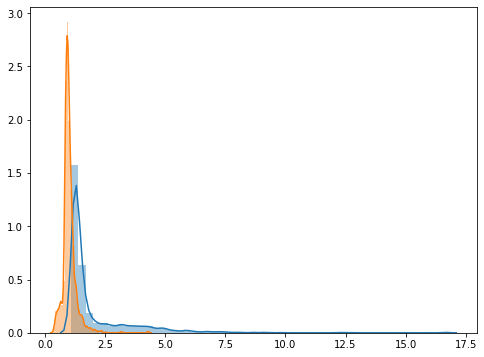

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(ipw)
sns.distplot(sw)

## Ước tính treatment effect với SW

Sau khi có stabilized IPW, ta có thể dùng 1 mô hình logistic như bài trước để ước tính treatment effect:

In [31]:
df2['Intercept'] = X.Intercept

gee = sm.GEE(
    df2.wt82_71,
    df2[['Intercept', 'qsmk']],
    groups=df2.seqn,
    weights=sw).fit()

gee.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                     wt82_71   No. Observations:                 1566
Model:                                 GEE   No. clusters:                     1566
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                           Gaussian   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                     1
Date:                     Thu, 02 Jul 2020   Scale:                          60.796
Covariance type:                    robust   Time:                         20:19:49
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7800      0.225      7.920      0.000       1.340       2.220
qsmk           3.4405      0.525      6.547      0.000       2.411       4.470
==============================================================================
Skew:                          0.1107   Kurtosis:                       3.7412
Centered skew:                 0.0000   Centered kurtosis:             -3.0000
==============================================================================
"""

Kết quả này tương đương với trong sách: $\theta$ = 3.4 kg (95%CI: 2.4 đến 4.5)

In [33]:
gee = sm.GEE(
    df2.wt82_71,
    df2[['Intercept', 'qsmk']],
    groups=df2.seqn,
    weights=ipw).fit()

gee.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                     wt82_71   No. Observations:                 1566
Model:                                 GEE   No. clusters:                     1566
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                           Gaussian   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                     1
Date:                     Thu, 02 Jul 2020   Scale:                          65.147
Covariance type:                    robust   Time:                         20:23:24
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7800      0.225      7.920      0.000       1.340       2.220
qsmk           3.4405      0.525      6.547      0.000       2.411       4.470
==============================================================================
Skew:                          0.1107   Kurtosis:                       3.7412
Centered skew:                 0.0000   Centered kurtosis:             -3.0000
==============================================================================
"""

So với kết quả khi dùng unstabilized IPW, ta không thấy có sự khác biệt nào cả ? Vậy tại sao lại phải mất công đi tính stabilized IPW làm chi ? Câu trả lời nằm ở trang 154, theo đó trong trường hợp can thiệp A là biến nhị phân, mô hình E[Outcome|A] = b0 + (A =1)* b1 là bão hòa; nhưng nếu có thêm yếu tố thời gian hay A là biến liên tục (thí dụ liều thuốc, cường độ can thiệp), khi đó stabilized ip weighting sẽ hiệu quả hơn. 

Bài thực hành đến đây tạm dừng, hẹn gặp lại trong Phần 3, sẽ bàn về Marginal structural model